In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn

from torch.autograd import Variable
from random import shuffle
from scipy.stats import gamma
import scipy

%matplotlib inline

## Generate Poisson data, compare Poisson vs. negBin model

I will generate observed data from a Poisson distribution with a certain lambda. Then I will train a MDN to approximate the posterior over model indices. As models I use a Poisson with Gamma prior and a negative Binomial with Beta prior. 

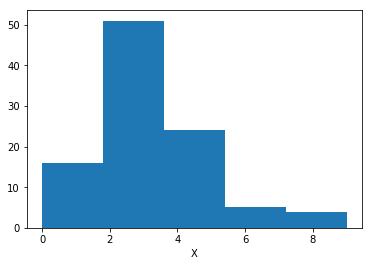

In [2]:
N = 100  # size of toy data
true_lam = 3.

# set prior parameters 
shape = 9. 
scale = .5
alpha = 2. 
beta = 5.

X_o = np.random.poisson(lam=true_lam, size=N)

X_var = Variable(torch.Tensor(X_o.astype(float)))

plt.hist(X_o, bins=5);
plt.xlabel('X');

## Define functions for generating data from the two different models

In [3]:
def generate_poisson(N): 
    
    # sample from prior
    theta = np.random.gamma(shape, scale)
    # generate samples
    x = np.random.poisson(lam=theta, size=N)
    
    sx = np.mean(x).astype(float)
    
    return theta, sx
    
def generate_negbin(N, r=3):
    # sample from prior
    theta = np.random.beta(alpha, beta)
    
    # generate samples
    x = np.random.negative_binomial(r, theta)
    
    # calculate summary stats
    sx = np.mean(x).astype(float)
    
    return theta, sx

def generate_dataset(n_samples, sample_size): 
    
    X = []
    thetas = []
    m = []

    # for every sample we want a triplet (m_i, theta, sx)
    for i in range(n_samples): 
        
        # sample model index 
        m_i = np.round(np.random.rand()).astype(int)
    
        # generate data from model 
        theta, sx = generate_negbin(N=sample_size) if m_i else generate_poisson(N=sample_size)
    
        X.append([sx])
        thetas.append([theta])
        m.append([m_i])
    
    return np.array(m), np.array(thetas), np.array(X)

## Define separate networks for fitting the prior parameter posterior and the model posterior

In [4]:
def batch_generator(dataset, batch_size=5):
    shuffle(dataset)
    N_full_batches = len(dataset) // batch_size
    for i in range(N_full_batches):
        idx_from = batch_size * i
        idx_to = batch_size * (i + 1)
        xs, ys = zip(*[(x, y) for x, y in dataset[idx_from:idx_to]])
        yield xs, ys

class MDN_phi(nn.Module):
    def __init__(self, ndim_input=1, ndim_output=1, n_hidden=5, n_components=1):
        super(MDN_phi, self).__init__()
        self.fc_in = nn.Linear(1, n_hidden)
        self.tanh = nn.Tanh()
        self.alpha_out = torch.nn.Sequential(
              nn.Linear(n_hidden, n_components),
              nn.Softmax())
        self.logsigma_out = nn.Linear(n_hidden, n_components)
        self.mu_out = nn.Linear(n_hidden, n_components)  

    def forward(self, x):
        out = self.fc_in(x)
        act = self.tanh(out)
        out_alpha = self.alpha_out(act)
        out_sigma = torch.exp(self.logsigma_out(act))
        out_mu = self.mu_out(act)
        return (out_alpha, out_sigma, out_mu)
    
    
class MDN_psi(nn.Module):
    
    def __init__(self, ndim_input=2, ndim_output=2, n_hidden=5, n_components=1):
        super(MDN_psi, self).__init__()
        self.fc_in = nn.Linear(ndim_input, n_hidden)
        self.tanh = nn.Tanh()
        self.m_out = torch.nn.Sequential(
              nn.Linear(n_hidden, ndim_output),
              nn.Softmax())

    def forward(self, x, m):
        out = self.fc_in(x, m)
        act = self.tanh(out)
        out_m = self.m_out(act)
        return out_m
    
def train(X, Y, model, optim, n_epochs=500, n_minibatch=50):
    dataset_train = [(x, y) for x, y in zip(X, Y)]

    for epoch in range(n_epochs): 
        bgen = batch_generator(dataset_train, n_minibatch)

        for j, (x_batch, y_batch) in enumerate(bgen):
            x_var = Variable(torch.Tensor(x_batch))
            y_var = Variable(torch.Tensor(y_batch))
                                                            
            (out_alpha, out_sigma, out_mu) = model(x_var)
            loss = mdn_loss_function(out_alpha, out_sigma, out_mu, y_var)
            
            optim.zero_grad()
            loss.backward()
            optim.step()

        if (epoch + 1) % 50 == 0:
            print("[epoch %04d] loss: %.4f" % (epoch + 1, loss.data[0]))
    
    return model, optim

## Define posterior model and corresponding loss function for learning theta

In [5]:
# this one is used to approximate the posterior with a mixture of Gaussians 
def gauss_pdf(y, mu, sigma, log=False):
    result = -0.5*torch.log(2*np.pi*sigma**2) - 1/(2*sigma**2) * (y.expand_as(mu) - mu)**2
    if log:
        return result
    else: 
        return torch.exp(result)

# the loss evaluates model (MoG) with the given data (y) and takes the log loss
def mdn_loss_function(out_alpha, out_sigma, out_mu, y):
    result = (gauss_pdf(y, out_mu, out_sigma, log=True) * out_alpha).squeeze() # sum? 
    result = torch.mean(result)  # mean over batch
    return -result

## Define something similar for learning the model comparison

In [6]:
def psi_loss_function(m, out): 
    M = m.size
    J = Variable(torch.Tensor([0]))

    for i in range(M):
        J += torch.log(out[i, m[i]])
        
    result = J / M
    
    return - result

In [7]:
k = 2
N = 2
m = np.random.randint(0, k, N)
v = np.random.rand(N, k)
print(v)
print(m)

[[ 0.29560509  0.04748683]
 [ 0.34925393  0.93889901]]
[0 0]


## Generate a large data set of triplets (m, theta, sx)

Then separate it into sets for model 1 and model 2 and train the phi networks separately. 

In [8]:
# generate data 
m, theta, X = generate_dataset(1000, 100)
# separate it 
mask = m.squeeze()
theta1, X1, = theta[mask==0], X[mask==0, :]
theta2, X2, = theta[mask==1], X[mask==1, :]

## Train the phi networks for estimating the theta posteriors

In [9]:
# now train the networks for the two models 
model1 = MDN_phi()
optim1 = torch.optim.Adam(model1.parameters(), lr=0.01)
model1, optim1 = train(X1, theta1, model=model1, optim=optim1)

[epoch 0050] loss: -0.0457
[epoch 0100] loss: -0.1595
[epoch 0150] loss: -0.1361
[epoch 0200] loss: -0.1088
[epoch 0250] loss: -0.2081
[epoch 0300] loss: -0.1801
[epoch 0350] loss: -0.0618
[epoch 0400] loss: -0.0222
[epoch 0450] loss: -0.2211
[epoch 0500] loss: -0.1764


In [10]:
model2 = MDN_phi()
optim2 = torch.optim.Adam(model2.parameters(), lr=0.01)
model2, optim2 = train(X1, theta2, model=model2, optim=optim2)

[epoch 0050] loss: -0.3681
[epoch 0100] loss: -0.4043
[epoch 0150] loss: -0.5317
[epoch 0200] loss: -0.5363
[epoch 0250] loss: -0.3621
[epoch 0300] loss: -0.3380
[epoch 0350] loss: -0.4914
[epoch 0400] loss: -0.3655
[epoch 0450] loss: -0.3482
[epoch 0500] loss: -0.5320


In [11]:
# now evaluate the model at the observed data 
stats_o = np.array(np.mean(X_o).astype(float)).reshape(1, 1)

X_var = Variable(torch.Tensor(stats_o))

(out_alpha, out_sigma, out_mu) = model1(X_var)

In [12]:
def get_posterior(model, X_o, thetas): 
    stats_o = np.array(np.mean(X_o).astype(float)).reshape(1, 1)

    X_var = Variable(torch.Tensor(stats_o))

    (out_alpha, out_sigma, out_mu) = model(X_var)    
    post = []

    for y in thetas: 
        y = Variable(torch.Tensor(np.array(y).reshape(1, 1)))
        th = (gauss_pdf(y, out_mu, out_sigma, log=False) * out_alpha).sum()
        post.append(th.data.numpy())
    post = np.array(post).squeeze()
    return post

In [13]:
thetas = np.linspace(0, 4, 100)
post1 = get_posterior(model1, X_o, thetas)
post2 = get_posterior(model2, X_o, thetas)

prior1 = gamma.pdf(x=thetas, a=shape, loc=0, scale=scale)
prior2 = scipy.stats.beta.pdf(x=thetas, a=alpha, b=beta)

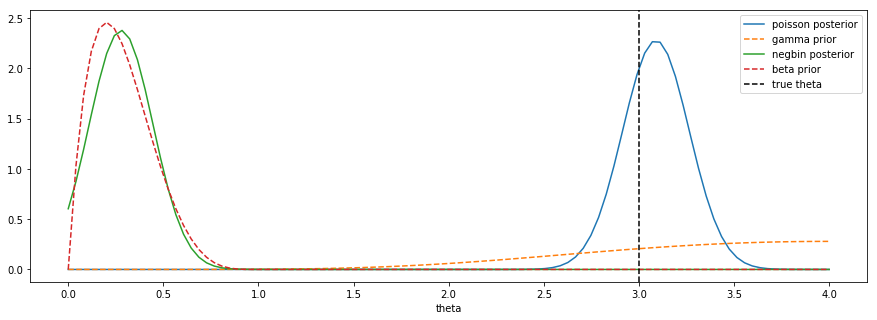

In [14]:
plt.figure(figsize=(15, 5))
plt.plot(thetas, post1.squeeze(), label='poisson posterior')
plt.plot(thetas, prior1, '--', label='gamma prior')

plt.plot(thetas, post2.squeeze(), label='negbin posterior')
plt.plot(thetas, prior2, '--', label='beta prior')

plt.axvline(x=true_lam, label='true theta', linestyle='--', color='k')
plt.xlabel('theta')
plt.legend();